Large Movie Review Dataset

This dataset contains movie reviews along with their associated binary sentiment polarity labels. It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided.

There are two directories [pos/, neg/] for the reviews with binary labels positive and negative. Within these directories, reviews are stored in text files named following the convention [[id]_[rating].txt] where [id] is a unique id and [rating] is the star rating for that review on a 1-10 scale. For example, the file [pos/200_8.txt] is the text for a positive-labeled example with unique id 200 and star rating 8/10 from IMDb. 

References
Potts, Christopher. 2011. On the negativity of negation. In Nan Li and David Lutz, eds., Proceedings of Semantics and Linguistic Theory 20, 636-659.



You need to build a machine-learning model (binary classifier) to predict sentiment for a given unlabeled text. This task includes the following major components:

1. Preprocess the data: remove stopwords, non-word characters, all lowercase, etc.


2. Convert text into feature representations and build the training / testing set: uni-gram, bi-gram, or tri-gram? Count or TFIDF? Some other features (be creative)?


3. Select a good model and test the performance: which model? How to evaluate?


4. Predict sentiment for a new (unlabeled) document / sentence: make prediction

### Feature Engineering 
```
 - unigram, bigrams, etc 
 - emojis in the text 
 - tf-idf
 - random forest
 - xgboost
 - length of words
```

In [4]:
import re
import nltk
import os, sys
import numpy as np
import pandas as pd

from nltk import pos_tag
from nltk.stem.porter import *
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

## Preprocess the data: remove stopwords, non-word characters, all lowercase, etc.

In [5]:
#stopwords list, porterstemmer for stemming
swlist = stopwords.words('english')
stemmer = PorterStemmer()

#all positive files and all negatives files are read using os.listdir into these two lists
pos_files = os.listdir('/Users/shrutigupta/Downloads/pos') #12500
neg_files = os.listdir('/Users/shrutigupta/Downloads/neg') #12500

appos = {"aren't":"are not", "can't" : "cannot", "couldn't": "could not", "didn't" : "did not", "doesn't": "does not", "don't": "do not"}

In [6]:
pos_corpus = []
for f in pos_files:
    
#     first reading in the data from each file into content 
    fname = '/Users/shrutigupta/Downloads/pos/' +f
    fh = open(fname, 'r')
    content = fh.read()
    
#     lowercasing the content and removing all non - alphanumeric characters
    processed_content = re.sub(r'[^a-zA-Z]', ' ',content.lower())
    
#     tokenized - changed the whole setence into a list of comma sepeprated words -> tokens
    words = word_tokenize(processed_content)  
    
#     identified the pos of each token 
    pos_words = pos_tag(words)
    
#     removing unwanted words |
#      - if word is in stopword
#      - if length of word is less than 3 its less important 
#      - if the pos of the word is not an an adjective, skip it
#      - append the stemmed word in that case
    clean_words = []
    for w in pos_words: 
        if w[0] in swlist or len(w[0]) <=3 or w[1] not in ('JJ', 'JJR', 'JJS'):
            continue
        else:
            clean_words.append(stemmer.stem(w[0]))
            
# joining list of stemmed words into a string and then forming a list of all strings obtsained from all docs -corpus    
    pos_content = ' '.join(clean_words)
    pos_corpus.append(pos_content)
    
# print(pos_corpus)

In [7]:
neg_corpus = []
for f in neg_files:
    
    fname = '/Users/shrutigupta/Downloads/neg/' +f
    fh = open(fname, 'r')
    content = fh.read()
    
    processed_content = re.sub(r'[^a-zA-Z]', ' ',content.lower())
    words = word_tokenize(processed_content)
    neg_words = pos_tag(words)
    
    clean_words = []
    for w in neg_words: 
        if w[0] in swlist or len(w[0]) <=3 or w[1] not in ('JJ', 'JJR', 'JJS'):
            continue
        clean_words.append(stemmer.stem(w[0]))
        
    neg_content = ' '.join(clean_words)
    neg_corpus.append(neg_content)
    
# print(neg_corpus)

In [8]:
print(len(pos_corpus))
print(len(neg_corpus))

#combine the two corpus:
corpus = pos_corpus + neg_corpus
print(len(corpus))

#making the target/decision variable y 
y = pd.Series(np.array([1]*len(pos_corpus)+ [0]*len(neg_corpus)))
print(len(y))

12500
12500
25000
25000


## Convert text into feature representations and build the training / testing set: uni-gram, bi-gram, or tri-gram? Count or TFIDF? Some other features (be creative)?

## Select a good model and test the performance: which model? How to evaluate?

### Feature Set 1 - tfidf Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,1))
X1 = vectorizer.fit_transform(corpus)
# print(X1.shape) #(25000, 19684)

In [13]:
## implementing LR model and evaluation of performaance

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size = 0.33, random_state = 5)

lr_model = LogisticRegression(random_state = 10)
lr_model.fit(X1_train, y1_train)

score = lr_model.score(X1_test, y1_test)
print("holdout score: ",score)

# cross validation 
scores = cross_val_score(lr_model, X1, y, cv = 10)
print("10 run scores:", scores, ',', np.mean(scores), ',', np.std(scores))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


holdout score:  0.824
10 run scores: [0.8316 0.8316 0.8204 0.8216 0.8368 0.8348 0.824  0.826  0.8284 0.8228] , 0.8278000000000001 , 0.005432494822823122


In [14]:
#logistic model prediction through grdiSearch Librar

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X1_train, y1_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.82
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


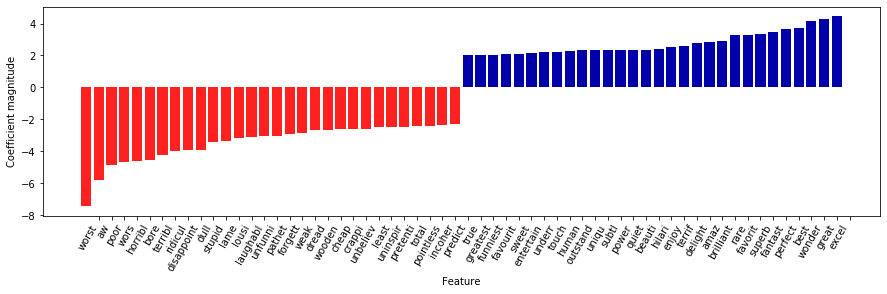

In [18]:
#implementing a graph to observe the insights on negative and positive wordds

import matplotlib.pyplot as plt
import mglearn
feature_names = vectorizer.get_feature_names()
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, feature_names, n_top_features=30)
plt.show()

In [19]:
lr = grid.best_estimator_
lr.fit(X1_train, y1_train)
lr.predict(X1_test)
print("Score: {:.2f}".format(lr.score(X1_test, y1_test)))

Score: 0.82


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
neg = ["The movie was a boring one, we did not like it, hated it mostly"]
print("Neg prediction: {}". format(lr.predict(vectorizer.transform(neg))))

Neg prediction: [0]


In [190]:
## implementing Naive Bayes and evaulation of performance

gnb = GaussianNB()
gnb.fit(X1_train.todense(), y1_train)

score = gnb.score(X1_test.todense(), y1_test)
print("holdout score: ",score)

# cross validation
scores = cross_val_score(gnb, X1.todense(), y, cv = 10)
print('10 run scores:', scores, ',',np.mean(scores), ',', np.std(scores))

holdout score:  0.5864242424242424
10 run scores: [0.5988 0.6008 0.5832 0.5888 0.5972 0.6112 0.566  0.5772 0.6056 0.592 ] , 0.5920799999999999 , 0.012988364023232484


In [ ]:
## implementing Gradient Boosting and evaulation of performance

gbc = GradientBoostingClassifier()
gbc.fit(X1_train.todense(), y1_train)

score = gbc.score(X1_test.todense(), y1_test)
print("holdout score: ",score)

# cross validation
scores = cross_val_score(gbc, X1.todense(), y, cv = 10)
print('10 run scores:', scores, ',',np.mean(scores), ',', np.std(scores))

In [ ]:
## implementing Random Forest and evaulation of performance

rf = RandomForestClassifier(n_jobs = -1)
rf.fit(X1_train, y1_train)

score = rf.score(X1_test.todense(), y1_test)
print("holdout score: ",score)

# cross validation
scores = cross_val_score(rf, X1.todense(), y, cv = 10)
print('10 run scores:', scores, ',',np.mean(scores), ',', np.std(scores))

### Feature Set 2 - bagOfWords Vectorizer 

### accuracy is lesser

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=19684)
X2 = bow_vectorizer.fit_transform(corpus)
# print(X2.shape) #(25000, 1000)

In [178]:
## implementing LR model and evaluation of performaance

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.33, random_state = 5)

lr_model = LogisticRegression(random_state = 10)
lr_model.fit(X2_train, y2_train)

score = lr_model.score(X2_test, y2_test)
print("holdout score: ",score)

# cross validation 
scores = cross_val_score(lr_model, X2, y, cv = 10)
print("10 run scores:", scores, ',', np.mean(scores), ',', np.std(scores))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


holdout score:  0.8155151515151515


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


10 run scores: [0.8264 0.8152 0.814  0.8136 0.8312 0.8196 0.82   0.8108 0.8132 0.8248] , 0.81888 , 0.006386986769987877
